In [119]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2
!mv Depth-Anything-V2 Depth_Anything_V2

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Total 142 (delta 0), reused 0 (delta 0), pack-reused 142 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 22.71 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [26]:
!wget https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Small/resolve/main/depth_anything_v2_metric_vkitti_vits.pth?download=true -O depth_anything_v2_metric_vkitti_vits.pth

--2025-05-04 17:23:44--  https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Small/resolve/main/depth_anything_v2_metric_vkitti_vits.pth?download=true
Resolving huggingface.co (huggingface.co)... 18.239.50.80, 18.239.50.16, 18.239.50.49, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.80|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/ff/9e/ff9ec3ee8db5ab81663fa79a7ae561bc8ee53042d8e48c4fcd8e7942fba39e9c/9203e538d35255c90dda4b7fedb47ff33fe725497bcca3b1e53b3a65ee63f0cb?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27depth_anything_v2_metric_vkitti_vits.pth%3B+filename%3D%22depth_anything_v2_metric_vkitti_vits.pth%22%3B&Expires=1746383025&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjM4MzAyNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2ZmLzllL2ZmOWVjM2VlOGRiNWFiODE2NjNmYTc5YTdhZTU2MWJjOGVlNTMwNDJkOGU0OGM0ZmNkOGU3

In [25]:
!wget https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Base/resolve/main/depth_anything_v2_metric_vkitti_vitb.pth?download=true -O depth_anything_v2_metric_vkitti_vitb.pth

--2025-05-04 17:23:05--  https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Base/resolve/main/depth_anything_v2_metric_vkitti_vitb.pth?download=true
Resolving huggingface.co (huggingface.co)... 18.239.50.16, 18.239.50.103, 18.239.50.80, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.16|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/24/41/2441b39e3c3e3a370e6939b2a24f9a09dbc008f34eccf3cab5f0358644a5e320/4dad67a7cc10b462bca48e6b8569c762b8eb3c1adada170a3851a6d3ba37bb3e?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27depth_anything_v2_metric_vkitti_vitb.pth%3B+filename%3D%22depth_anything_v2_metric_vkitti_vitb.pth%22%3B&Expires=1746382986&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjM4Mjk4Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzI0LzQxLzI0NDFiMzllM2MzZTNhMzcwZTY5MzliMmEyNGY5YTA5ZGJjMDA4ZjM0ZWNjZjNjYWI1ZjAz

In [27]:
!wget https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Large/resolve/main/depth_anything_v2_metric_vkitti_vitl.pth?download=true -O depth_anything_v2_metric_vkitti_vitl.pth

--2025-05-04 17:24:21--  https://huggingface.co/depth-anything/Depth-Anything-V2-Metric-VKITTI-Large/resolve/main/depth_anything_v2_metric_vkitti_vitl.pth?download=true
Resolving huggingface.co (huggingface.co)... 18.239.50.103, 18.239.50.16, 18.239.50.80, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.103|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/2f/11/2f11b8475d910c627673fdbb31a1e8a1e18d4d85ee29a0e12a6a2060dbdff92d/239b1054a369e66da2576e9a118d6d7c12d90dc8ebe609579a9a09cd8e05fe38?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27depth_anything_v2_metric_vkitti_vitl.pth%3B+filename%3D%22depth_anything_v2_metric_vkitti_vitl.pth%22%3B&Expires=1746383061&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjM4MzA2MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzJmLzExLzJmMTFiODQ3NWQ5MTBjNjI3NjczZmRiYjMxYTFlOGExZTE4ZDRkODVlZTI5YTBlMTJhNm

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.cm
import pandas as pd

from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from pathlib import Path
from typing import Callable
from Depth_Anything_V2.metric_depth.depth_anything_v2.dpt import DepthAnythingV2

xFormers not available
xFormers not available


In [2]:
def colorize(
    value: torch.Tensor | np.ndarray,
    vmin: float | None = None,
    vmax: float | None = None,
    cmap: str = "magma_r",
    invalid_val: float = -99,
    invalid_mask: np.ndarray | None = None,
    background_color: tuple[int, int, int, int] = (128, 128, 128, 255),
    gamma_corrected: bool = False,
    value_transform: Callable[[np.ndarray], np.ndarray] | None = None,
) -> np.ndarray:
    """Converts a depth map to a color image.

    Args:
        value (torch.Tensor, numpy.ndarray): Input depth map. Shape: (H, W) or (1, H, W) or (1, 1, H, W). All singular dimensions are squeezed
        vmin (float, optional): vmin-valued entries are mapped to start color of cmap. If None, value.min() is used. Defaults to None.
        vmax (float, optional):  vmax-valued entries are mapped to end color of cmap. If None, value.max() is used. Defaults to None.
        cmap (str, optional): matplotlib colormap to use. Defaults to 'magma_r'.
        invalid_val (int, optional): Specifies value of invalid pixels that should be colored as 'background_color'. Defaults to -99.
        invalid_mask (numpy.ndarray, optional): Boolean mask for invalid regions. Defaults to None.
        background_color (tuple[int], optional): 4-tuple RGB color to give to invalid pixels. Defaults to (128, 128, 128, 255).
        gamma_corrected (bool, optional): Apply gamma correction to colored image. Defaults to False.
        value_transform (Callable, optional): Apply transform function to valid pixels before coloring. Defaults to None.

    Returns:
        numpy.ndarray, dtype - uint8: Colored depth map. Shape: (H, W, 4)
    """
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    value = value.squeeze()
    if invalid_mask is None:
        invalid_mask = value == invalid_val
    mask = np.logical_not(invalid_mask)

    # normalize
    vmin = np.percentile(value[mask], 2) if vmin is None else vmin
    vmax = np.percentile(value[mask], 85) if vmax is None else vmax
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.0

    # squeeze last dim if it exists
    # grey out the invalid values

    value[invalid_mask] = np.nan
    cmapper = matplotlib.colormaps[cmap]
    if value_transform:
        value = value_transform(value)
        # value = value / value.max()
    value = cmapper(value, bytes=True)  # (n x m x4)

    # img = value[:, :, :]
    img = value[...]
    img[invalid_mask] = background_color

    #     return img.transpose((2, 0, 1))
    if gamma_corrected:
        # gamma correction
        img = img / 255
        img = np.power(img, 2.2)
        img = img * 255
        img = img.astype(np.uint8)
    return img

In [3]:
DEVICE = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}
encoder = 'vits' # or 'vits', 'vitb'
dataset = 'vkitti' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 80 # 20 for indoor model, 80 for outdoor model
min_depth = 0.001

model_small = DepthAnythingV2(**model_configs[encoder], max_depth=max_depth)
model_small.load_state_dict(
    torch.load(
        f"depth_anything_v2_metric_{dataset}_{encoder}.pth",
        map_location="cpu",
        weights_only=True,
    ),
)
model_small.to(DEVICE)
model_small.eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
    

In [4]:
image = Image.open("mountains.jpg")

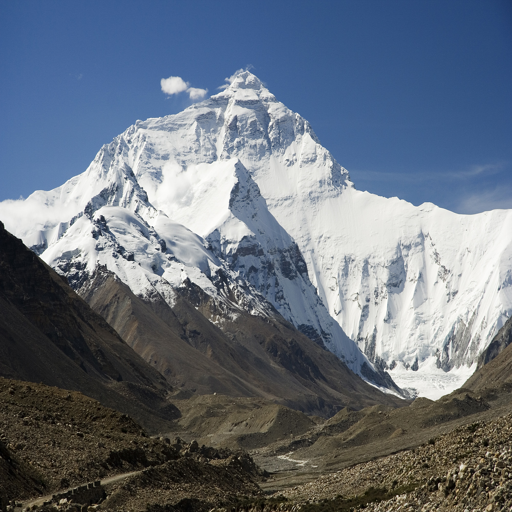

In [5]:
display(image.resize((512, 512)))

In [6]:
model_small.eval()
pred = model_small.infer_image(np.ascontiguousarray(image))

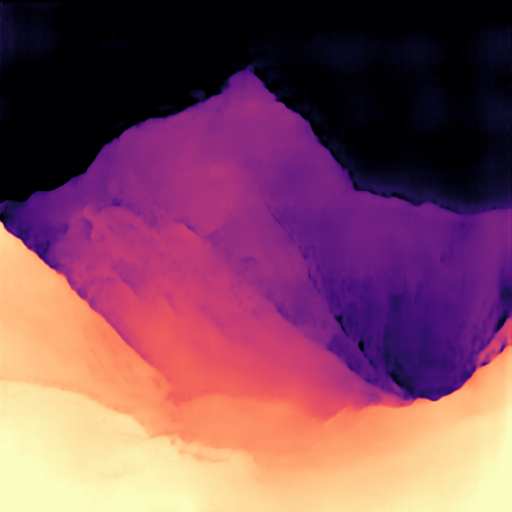

In [7]:
depth_img = Image.fromarray(colorize(pred))
display(depth_img.resize((512, 512)))

In [8]:
KITTI_DEPTH_SELECTION_PATH = Path("datasets/depth_selection")

In [9]:
class KittiDepthDatasetSelection(Dataset):
    def __init__(self):
        super().__init__()
        self.image_path = KITTI_DEPTH_SELECTION_PATH / "val_selection_cropped" / "image"
        self.ground_truth_path = (
            KITTI_DEPTH_SELECTION_PATH / "val_selection_cropped" / "groundtruth_depth"
        )
        self.image_paths, self.ground_truth_paths = self._prepare_data()

    def _get_image_params(self, image_path: Path) -> tuple[str, str, str, str]:
        params = image_path.stem.split("_")
        date = f"{params[0]}_{params[1]}_{params[2]}"
        record_index = params[4]
        index = params[-3]
        cam = params[-1]
        return date, record_index, index, cam

    def _prepare_data(self) -> tuple[list[Path], list[Path]]:
        image_paths = []
        ground_truth_paths = []
        for image_path in self.image_path.iterdir():
            date, record_index, index, cam = self._get_image_params(image_path)
            ground_truth_path = (
                self.ground_truth_path
                / f"{date}_drive_{record_index}_sync_groundtruth_depth_{index}_image_{cam}.png"
            )
            if not ground_truth_path.exists():
                print(f"Ground truth path {ground_truth_path} does not exist")
            image_paths.append(image_path)
            ground_truth_paths.append(ground_truth_path)
        return image_paths, ground_truth_paths

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> tuple[str, np.ndarray, np.ndarray, np.ndarray]:
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        img_path = img_path.relative_to(KITTI_DEPTH_SELECTION_PATH)
        image = np.ascontiguousarray(image)
        ground_truth = Image.open(self.ground_truth_paths[idx])
        ground_truth = np.ascontiguousarray(ground_truth).astype(float) / 256.0
        valid_mask = (ground_truth > 0).astype(int)
        return img_path.as_posix(), image, ground_truth, valid_mask

In [10]:
selection_dataset = KittiDepthDatasetSelection()

In [11]:
def eval_depth(pred: torch.Tensor, target: torch.Tensor) -> dict[str, float]:
    assert pred.shape == target.shape

    thresh = torch.max((target / pred), (pred / target))

    d1 = torch.sum(thresh < 1.25).float() / len(thresh)
    d2 = torch.sum(thresh < 1.25 ** 2).float() / len(thresh)
    d3 = torch.sum(thresh < 1.25 ** 3).float() / len(thresh)

    diff = pred - target
    diff_log = torch.log(pred) - torch.log(target)

    abs_rel = torch.mean(torch.abs(diff) / target)
    sq_rel = torch.mean(torch.pow(diff, 2) / target)

    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
    rmse_log = torch.sqrt(torch.mean(torch.pow(diff_log , 2)))

    log10 = torch.mean(torch.abs(torch.log10(pred) - torch.log10(target)))
    silog = torch.sqrt(torch.pow(diff_log, 2).mean() - 0.5 * torch.pow(diff_log.mean(), 2))

    return {'d1': d1.item(), 'd2': d2.item(), 'd3': d3.item(), 'abs_rel': abs_rel.item(), 'sq_rel': sq_rel.item(), 
            'rmse': rmse.item(), 'rmse_log': rmse_log.item(), 'log10':log10.item(), 'silog':silog.item()}

In [12]:
idx = 67
_, img, true_depth, valid_mask = selection_dataset[idx]

with torch.no_grad():
    pred = model_small.infer_image(img)
    pred = torch.from_numpy(pred)

true_depth = torch.from_numpy(true_depth)
valid_mask = torch.from_numpy(valid_mask)
mask = (valid_mask == 1) & (true_depth >= min_depth) & (true_depth <= max_depth)

eval_depth(pred[mask], true_depth[mask])

{'d1': 0.934360146522522,
 'd2': 0.9780454039573669,
 'd3': 0.9957575798034668,
 'abs_rel': 0.09500847624219573,
 'sq_rel': 0.3092966161387171,
 'rmse': 2.842659092757464,
 'rmse_log': 0.13834966003867227,
 'log10': 0.03877284411697136,
 'silog': 0.13829408244792293}

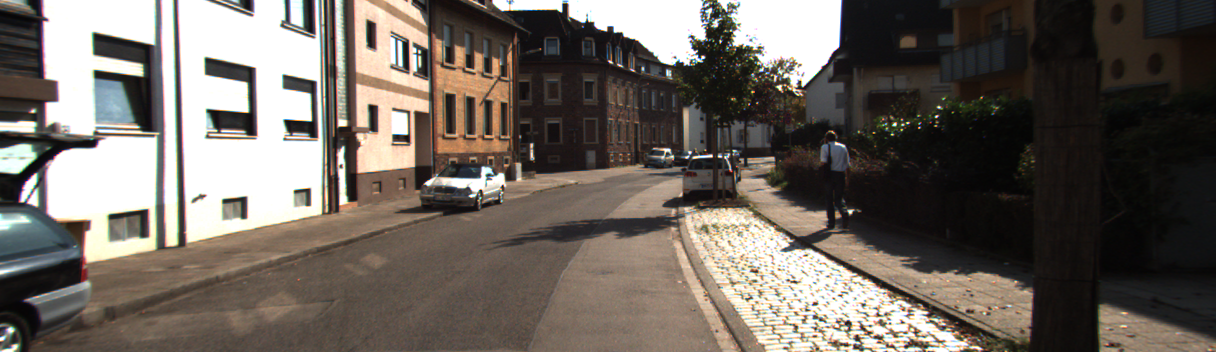

In [13]:
Image.fromarray(img.astype("uint8"))

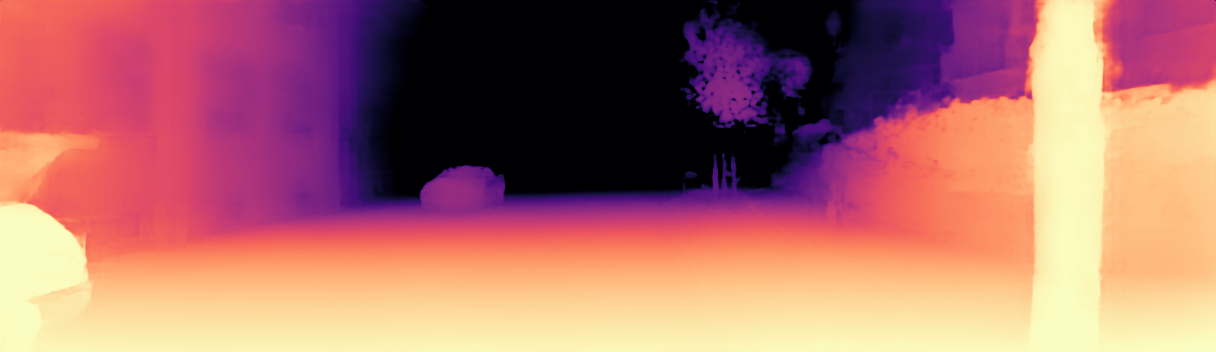

In [14]:
depth_colorized = colorize(pred)
Image.fromarray(depth_colorized.astype("uint8"))

In [15]:
def evaluate_model(model: nn.Module, dataset: KittiDepthDatasetSelection) -> pd.DataFrame:
    metrics = []

    for path_to, img, true_depth, valid_mask in tqdm(
        selection_dataset, total=len(selection_dataset)
    ):
        with torch.no_grad():
            pred = model.infer_image(img)
            pred = torch.from_numpy(pred)

        true_depth = torch.from_numpy(true_depth)
        valid_mask = torch.from_numpy(valid_mask)
        mask = (valid_mask == 1) & (true_depth >= min_depth) & (true_depth <= max_depth)

        metrics.append({"name": path_to, **eval_depth(pred[mask], true_depth[mask])})

    return pd.DataFrame(metrics)

In [16]:
metrics = evaluate_model(model_small, selection_dataset)
metrics.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,name,d1,d2,d3,abs_rel,sq_rel,rmse,rmse_log,log10,silog
0,val_selection_cropped/image/2011_09_26_drive_0...,0.758553,0.953081,0.987277,0.178202,1.012570,6.514962,0.231995,0.087391,0.187775
1,val_selection_cropped/image/2011_09_26_drive_0...,0.907961,0.993830,0.998636,0.100636,0.321815,2.488253,0.129330,0.041352,0.128771
2,val_selection_cropped/image/2011_10_03_drive_0...,0.647436,0.842179,0.947696,0.156741,1.296155,7.045970,0.298624,0.081786,0.281834
3,val_selection_cropped/image/2011_09_26_drive_0...,0.918696,0.985201,0.997082,0.078967,0.454174,4.462308,0.129201,0.035677,0.127079
4,val_selection_cropped/image/2011_09_26_drive_0...,0.882132,0.969461,0.984869,0.096727,0.716821,5.003948,0.183830,0.046084,0.174891


In [18]:
print("Small model performance")
metrics[metrics.columns[1:]].mean()

Small model performance


d1          0.789861
d2          0.921184
d3          0.967834
abs_rel     0.140257
sq_rel      1.039275
rmse        5.765793
rmse_log    0.229262
log10       0.068140
silog       0.213615
dtype: float64

In [19]:
encoder = 'vitb' # or 'vits', 'vitb'
dataset = 'vkitti' # 'hypersim' for indoor model, 'vkitti' for outdoor model

model_base = DepthAnythingV2(**model_configs[encoder], max_depth=max_depth)
model_base.load_state_dict(
    torch.load(
        f"depth_anything_v2_metric_{dataset}_{encoder}.pth",
        map_location="cpu",
        weights_only=True,
    ),
)
model_base.to(DEVICE)
model_base.eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
    

In [20]:
metrics = evaluate_model(model_base, selection_dataset)
metrics.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,name,d1,d2,d3,abs_rel,sq_rel,rmse,rmse_log,log10,silog
0,val_selection_cropped/image/2011_09_26_drive_0...,0.913282,0.980100,0.994100,0.097140,0.528678,4.952158,0.149333,0.044611,0.142757
1,val_selection_cropped/image/2011_09_26_drive_0...,0.899834,0.989904,0.998053,0.101188,0.397258,2.750484,0.136091,0.039985,0.130147
2,val_selection_cropped/image/2011_10_03_drive_0...,0.739970,0.949433,0.998484,0.120319,0.627223,4.329198,0.203166,0.057105,0.196670
3,val_selection_cropped/image/2011_09_26_drive_0...,0.929460,0.988864,0.997380,0.080397,0.441257,4.316454,0.124583,0.035374,0.124476
4,val_selection_cropped/image/2011_09_26_drive_0...,0.923470,0.984563,0.989520,0.069990,0.465620,3.711909,0.138825,0.031529,0.137170


In [21]:
print("Base model performance")
metrics[metrics.columns[1:]].mean()

Base model performance


d1          0.849912
d2          0.960514
d3          0.986712
abs_rel     0.116018
sq_rel      0.738437
rmse        4.628780
rmse_log    0.178442
log10       0.051267
silog       0.172296
dtype: float64

In [22]:
encoder = 'vitl' # or 'vits', 'vitb'
dataset = 'vkitti' # 'hypersim' for indoor model, 'vkitti' for outdoor model

model_large = DepthAnythingV2(**model_configs[encoder], max_depth=max_depth)
model_large.load_state_dict(
    torch.load(
        f"depth_anything_v2_metric_{dataset}_{encoder}.pth",
        map_location="cpu",
        weights_only=True,
    ),
)
model_large.to(DEVICE)
model_large.eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=Fal

In [23]:
metrics = evaluate_model(model_large, selection_dataset)
metrics.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,name,d1,d2,d3,abs_rel,sq_rel,rmse,rmse_log,log10,silog
0,val_selection_cropped/image/2011_09_26_drive_0...,0.898942,0.971434,0.996426,0.098453,0.419473,3.197434,0.149102,0.039301,0.148058
1,val_selection_cropped/image/2011_09_26_drive_0...,0.941141,0.995128,0.999219,0.091999,0.278559,2.352630,0.119215,0.037171,0.114569
2,val_selection_cropped/image/2011_10_03_drive_0...,0.931130,0.988244,0.998704,0.075191,0.327310,2.982561,0.118875,0.030256,0.116316
3,val_selection_cropped/image/2011_09_26_drive_0...,0.963316,0.991291,0.998035,0.075343,0.299190,3.149633,0.108572,0.031606,0.107139
4,val_selection_cropped/image/2011_09_26_drive_0...,0.954576,0.983517,0.991526,0.071385,0.471037,3.727431,0.125218,0.030322,0.125137


In [24]:
print("Large model performance")
metrics[metrics.columns[1:]].mean()

Large model performance


d1          0.897171
d2          0.981626
d3          0.995151
abs_rel     0.102981
sq_rel      0.523289
rmse        3.561642
rmse_log    0.144700
log10       0.042055
silog       0.140048
dtype: float64